In [6]:

import sys
print(sys.executable)


/Users/sara2828/Downloads/falcon-desert-semantic/venv/bin/python


In [7]:

import torch
print(torch.__version__)
print(torch.cuda.is_available())


2.10.0
False


In [8]:
import os
print("PWD:", os.getcwd())
print("Files here:", os.listdir("."))


PWD: /Users/sara2828/Downloads/falcon-desert-semantic/notebooks
Files here: ['best_model_weighted_dice_128_full.pth', 'training_log.txt', 'best_model_weighted_dice.pth', 'miou_curve.png', 'traning.ipynb', 'loss_curve.png', 'best_model.pth', 'final_metrics.json', 'best_model_subset.pth', 'best_model_weighted_dice_by_iou.pth', 'best_model_weighted_dice_256_finetune.pth']


In [9]:
import os

print("PWD:", os.getcwd())
print("data exists:", os.path.exists("../data"))
print("contents of data:", os.listdir("../data"))


PWD: /Users/sara2828/Downloads/falcon-desert-semantic/notebooks
data exists: True
contents of data: ['.DS_Store', 'Offroad_Segmentation_Scripts', 'Offroad_Segmentation_Training_Dataset', 'Offroad_Segmentation_testImages']


In [10]:
import os

DATASET_ROOT = "../data"

TRAIN_DIR = os.path.join(DATASET_ROOT, "Offroad_Segmentation_Training_Dataset")
TEST_DIR  = os.path.join(DATASET_ROOT, "Offroad_Segmentation_testImages")

print("Train dir exists:", os.path.exists(TRAIN_DIR), TRAIN_DIR)
print("Test dir exists:", os.path.exists(TEST_DIR), TEST_DIR)

print("Train contents:", os.listdir(TRAIN_DIR))
print("Test contents:", os.listdir(TEST_DIR))


Train dir exists: True ../data/Offroad_Segmentation_Training_Dataset
Test dir exists: True ../data/Offroad_Segmentation_testImages
Train contents: ['train', 'val']
Test contents: ['Color_Images', 'Segmentation']


In [11]:
import os, torch

DATASET_ROOT = "../data"

TRAIN_DIR = os.path.join(DATASET_ROOT, "Offroad_Segmentation_Training_Dataset", "train")
VAL_DIR   = os.path.join(DATASET_ROOT, "Offroad_Segmentation_Training_Dataset", "val")

TEST_DIR  = os.path.join(DATASET_ROOT, "Offroad_Segmentation_testImages")  # for inference later

IMAGE_SIZE = 256
BATCH_SIZE = 2          # CPU friendly
EPOCHS = 2              # start with 2 to test
LR = 1e-3

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
SAVE_PATH = "best_model.pth"   # save in repo root (simple)

print("TRAIN_DIR:", TRAIN_DIR)
print("VAL_DIR:", VAL_DIR)
print("DEVICE:", DEVICE)


TRAIN_DIR: ../data/Offroad_Segmentation_Training_Dataset/train
VAL_DIR: ../data/Offroad_Segmentation_Training_Dataset/val
DEVICE: cpu


In [12]:
# Label remapping (example based on your output)
LABEL_MAP = {0:0, 1:1, 2:2, 3:3, 27:4, 39:5}
NUM_CLASSES = len(LABEL_MAP)

print("NUM_CLASSES:", NUM_CLASSES)


NUM_CLASSES: 6


In [1]:
import os
import cv2
import torch
from torch.utils.data import Dataset
from torchvision import transforms

class DesertDataset(Dataset):
    def __init__(self, root_dir, image_size=256):
        self.image_dir = os.path.join(root_dir, "Color_Images")
        self.mask_dir = os.path.join(root_dir, "Segmentation")

        self.images = sorted(os.listdir(self.image_dir))

        self.image_size = image_size

        self.transform = transforms.ToTensor()

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]

        img_path = os.path.join(self.image_dir, img_name)
        mask_path = os.path.join(self.mask_dir, img_name)

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (self.image_size, self.image_size))

        mask = cv2.imread(mask_path, 0)
        mask = cv2.resize(mask, (self.image_size, self.image_size), interpolation=cv2.INTER_NEAREST)
        mask = torch.from_numpy(mask).long()

        # remap labels
        mapped = torch.empty_like(mask)
        for k, v in LABEL_MAP.items():
            mapped[mask == k] = v
        mask = mapped

        image = self.transform(image)
        

        return image, mask

In [5]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import os

def train():
    train_dataset = DesertDataset(TRAIN_DIR, IMAGE_SIZE)
    val_dataset = DesertDataset(VAL_DIR, IMAGE_SIZE)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

    model = UNet(in_channels=3, out_channels=7).to(DEVICE)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)

    best_loss = float("inf")

    for epoch in range(EPOCHS):
        model.train()
        running_loss = 0

        for images, masks in train_loader:
            images = images.to(DEVICE)
            masks = masks.to(DEVICE)

            outputs = model(images)

            loss = criterion(outputs, masks)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {epoch_loss:.4f}")

        if epoch_loss < best_loss:
            best_loss = epoch_loss
            torch.save(model.state_dict(), MODEL_PATH)
            print("Model Saved!")

if __name__ == "__main__":
    os.makedirs("../models", exist_ok=True)
    train()

NameError: name 'IMAGE_SIZE' is not defined

In [13]:
import torch
import torch.nn as nn

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)


class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=7):
        super(UNet, self).__init__()

        self.down1 = DoubleConv(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)

        self.down2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)

        self.down3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(2)

        self.bottleneck = DoubleConv(256, 512)

        self.up3 = nn.ConvTranspose2d(512, 256, 2, 2)
        self.conv3 = DoubleConv(512, 256)

        self.up2 = nn.ConvTranspose2d(256, 128, 2, 2)
        self.conv2 = DoubleConv(256, 128)

        self.up1 = nn.ConvTranspose2d(128, 64, 2, 2)
        self.conv1 = DoubleConv(128, 64)

        self.final = nn.Conv2d(64, out_channels, 1)

    def forward(self, x):
        d1 = self.down1(x)
        p1 = self.pool1(d1)

        d2 = self.down2(p1)
        p2 = self.pool2(d2)

        d3 = self.down3(p2)
        p3 = self.pool3(d3)

        bottleneck = self.bottleneck(p3)

        up3 = self.up3(bottleneck)
        up3 = torch.cat([up3, d3], dim=1)
        up3 = self.conv3(up3)

        up2 = self.up2(up3)
        up2 = torch.cat([up2, d2], dim=1)
        up2 = self.conv2(up2)

        up1 = self.up1(up2)
        up1 = torch.cat([up1, d1], dim=1)
        up1 = self.conv1(up1)

        return self.final(up1)

mask unique values: [0, 1, 2, 3, 27, 39]

That means your labels are not continuous (it’s skipping to 27 and 39). If you train like this, CrossEntropyLoss will think you have 40 classes (0..39), which is wrong and will waste learning.

✅ What to do

You must remap mask values to compact class IDs:
{0,1,2,3,27,39} → {0,1,2,3,4,5}

So your NUM_CLASSES = 6 (based on what we saw so far).

Step 1: Add a remapping table

Use this mapping in your dataset class:

In [19]:
import numpy as np
import torch

LABEL_MAP = {0:0, 1:1, 2:2, 3:3, 27:4, 39:5}


In [25]:
import os, glob
import cv2
import numpy as np

TRAIN_DIR = "../data/Offroad_Segmentation_Training_Dataset/train"
mask_dir = os.path.join(TRAIN_DIR, "Segmentation")

mask_paths = sorted(glob.glob(os.path.join(mask_dir, "*")))
print("Total masks:", len(mask_paths))

vals = set()
for p in mask_paths[:500]:   # scan first 500 (fast). increase later if needed
    m = cv2.imread(p, 0)
    vals.update(np.unique(m).tolist())

vals = sorted(vals)
print("Unique raw label values found:", vals)
print("Count:", len(vals))


Total masks: 2857
Unique raw label values found: [0, 1, 2, 3, 27, 39]
Count: 6


In [26]:
LABEL_VALUES = [0, 1, 2, 3, 27, 39]
LABEL_MAP = {v:i for i, v in enumerate(LABEL_VALUES)}
NUM_CLASSES = len(LABEL_VALUES)

print("NUM_CLASSES:", NUM_CLASSES)
print("LABEL_MAP:", LABEL_MAP)


NUM_CLASSES: 6
LABEL_MAP: {0: 0, 1: 1, 2: 2, 3: 3, 27: 4, 39: 5}


In [27]:
TRAIN_DIR = "../data/Offroad_Segmentation_Training_Dataset/train"
ds = DesertDataset(TRAIN_DIR, image_size=256)
_, m = ds[0]
print("Unique after mapping:", torch.unique(m))


Unique after mapping: tensor([0, 1, 2, 3, 4, 5])


dataloaders

In [28]:
from torch.utils.data import DataLoader

TRAIN_DIR = "../data/Offroad_Segmentation_Training_Dataset/train"
VAL_DIR   = "../data/Offroad_Segmentation_Training_Dataset/val"

BATCH_SIZE = 2

train_ds = DesertDataset(TRAIN_DIR, image_size=256)
val_ds   = DesertDataset(VAL_DIR, image_size=256)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print("Train batches:", len(train_loader))
print("Val batches:", len(val_loader))


Train batches: 1429
Val batches: 159


Initialize U-Net model (new cell)

In [29]:
import torch
import torch.nn as nn
import torch.optim as optim

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

NUM_CLASSES = len(LABEL_MAP)

model = UNet(out_channels=NUM_CLASSES).to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

print("Model ready with", NUM_CLASSES, "classes")


Model ready with 6 classes


Training loop (new cell)


In [31]:
from torch.utils.data import Subset

train_ds = Subset(train_ds, range(500))
val_ds   = Subset(val_ds, range(150))

train_loader = DataLoader(train_ds, batch_size=2, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=2)


In [32]:
import torch

model.load_state_dict(torch.load("best_model.pth", map_location=DEVICE))
print("✅ Loaded best_model.pth")


✅ Loaded best_model.pth


Total images: 2857
Total masks: 2857

Checking random samples...

File: cc0000528.png
Image shape: (540, 960, 3)
Mask shape: (540, 960)
Mask classes: [ 0  1  2  3 27 39]


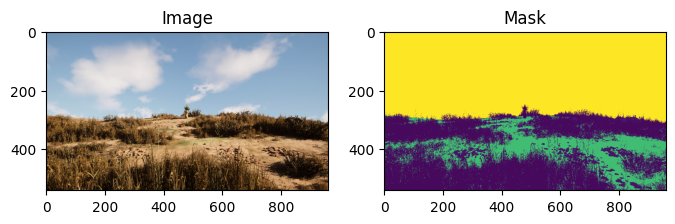


File: cc0000339.png
Image shape: (540, 960, 3)
Mask shape: (540, 960)
Mask classes: [ 0  1  2  3 27 39]


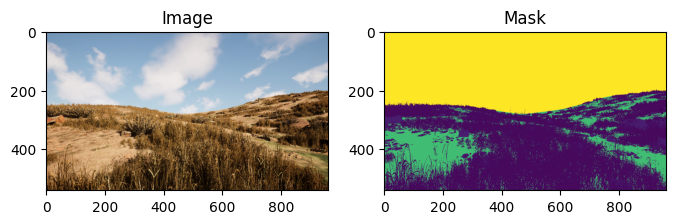


File: w0000148.png
Image shape: (540, 960, 3)
Mask shape: (540, 960)
Mask classes: [ 0  1  2  3 27 39]


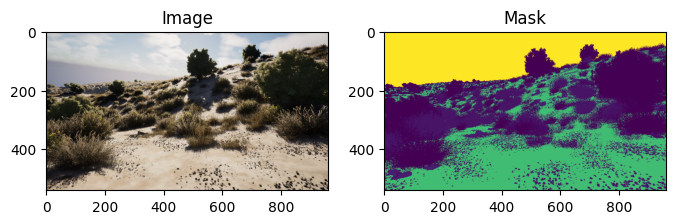


File: ww10000631.png
Image shape: (540, 960, 3)
Mask shape: (540, 960)
Mask classes: [ 0  1  2  3 27 39]


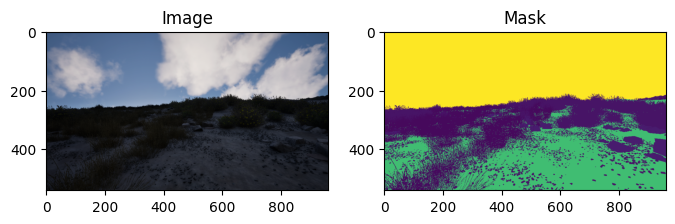


File: ww10000317.png
Image shape: (540, 960, 3)
Mask shape: (540, 960)
Mask classes: [ 0  1  2  3 27 39]


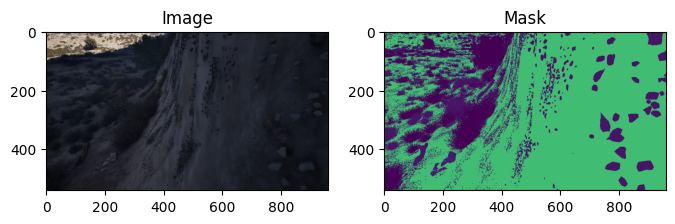

In [35]:
import os
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt

IMAGE_DIR = "../data/Offroad_Segmentation_Training_Dataset/train/Color_Images"
  # change path
MASK_DIR = "../data/Offroad_Segmentation_Training_Dataset/train/Segmentation"     # change path

# 1️⃣ total files check
image_files = os.listdir(IMAGE_DIR)
mask_files = os.listdir(MASK_DIR)

print("Total images:", len(image_files))
print("Total masks:", len(mask_files))

if len(image_files) != len(mask_files):
    print("⚠️ WARNING: Images and masks count mismatch!")


# 2️⃣ random sample check
print("\nChecking random samples...")

for i in range(5):
    file = random.choice(image_files)

    img_path = os.path.join(IMAGE_DIR, file)
    mask_path = os.path.join(MASK_DIR, file)

    if not os.path.exists(mask_path):
        print(f"Missing mask for {file}")
        continue

    image = cv2.imread(img_path)
    mask = cv2.imread(mask_path, 0)

    print(f"\nFile: {file}")
    print("Image shape:", image.shape)
    print("Mask shape:", mask.shape)
    print("Mask classes:", np.unique(mask))

    # visualize
    plt.figure(figsize=(8,3))

    plt.subplot(1,2,1)
    plt.title("Image")
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    plt.subplot(1,2,2)
    plt.title("Mask")
    plt.imshow(mask)

    plt.show()

In [38]:
import torch

model.load_state_dict(torch.load("best_model_subset.pth", map_location=DEVICE))
model.eval()
print("✅ Loaded best_model_subset.pth")


✅ Loaded best_model_subset.pth


In [39]:
import torch

def mean_iou(model, loader, num_classes):
    model.eval()
    iou_sum = torch.zeros(num_classes)
    count = torch.zeros(num_classes)

    with torch.no_grad():
        for imgs, masks in loader:
            imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)

            logits = model(imgs)
            preds = torch.argmax(logits, dim=1)

            for cls in range(num_classes):
                pred_c = preds == cls
                mask_c = masks == cls

                inter = (pred_c & mask_c).sum().item()
                union = (pred_c | mask_c).sum().item()

                if union > 0:
                    iou_sum[cls] += inter / union
                    count[cls] += 1

    per_class_iou = iou_sum / torch.clamp(count, min=1)
    return per_class_iou, per_class_iou.mean().item()

NUM_CLASSES = len(LABEL_MAP)

per_class, miou = mean_iou(model, val_loader, NUM_CLASSES)
print("Per-class IoU:", per_class.cpu().numpy())
print("Mean IoU (mIoU):", miou)


Per-class IoU: [0.23223063 0.44589624 0.01094225 0.03369225 0.4611625  0.9838964 ]
Mean IoU (mIoU): 0.3613033592700958


In [40]:
from torch.utils.data import DataLoader

IMAGE_SIZE = 128
BATCH_SIZE = 4  # if memory error, make it 2

TRAIN_DIR = "../data/Offroad_Segmentation_Training_Dataset/train"
VAL_DIR   = "../data/Offroad_Segmentation_Training_Dataset/val"

train_ds = DesertDataset(TRAIN_DIR, image_size=IMAGE_SIZE)
val_ds   = DesertDataset(VAL_DIR, image_size=IMAGE_SIZE)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print("Train size:", len(train_ds), "Val size:", len(val_ds))

Train size: 2857 Val size: 317


In [41]:
import torch

NUM_CLASSES = len(LABEL_MAP)

def compute_class_weights(loader, num_classes):
    counts = torch.zeros(num_classes)
    for _, masks in loader:
        for c in range(num_classes):
            counts[c] += (masks == c).sum()
    weights = 1.0 / (counts + 1e-6)
    weights = weights / weights.sum() * num_classes
    return weights

weights = compute_class_weights(train_loader, NUM_CLASSES)
print("Class weights:", weights)


Class weights: tensor([0.5284, 0.2517, 0.6898, 4.1923, 0.2062, 0.1317])


In [42]:
import torch

def class_pixel_counts(loader, num_classes, batches=200):
    counts = torch.zeros(num_classes)
    seen = 0
    for _, masks in loader:
        for c in range(num_classes):
            counts[c] += (masks == c).sum()
        seen += 1
        if seen >= batches:
            break
    return counts

counts = class_pixel_counts(train_loader, NUM_CLASSES, batches=200)
print("Pixel counts (first 200 batches):", counts)
print("Percent:", (counts / counts.sum() * 100))


Pixel counts (first 200 batches): tensor([1270347., 2601129.,  924139.,  152696., 3209220., 4949669.])
Percent: tensor([ 9.6920, 19.8450,  7.0506,  1.1650, 24.4844, 37.7630])


In [43]:
import torch.nn as nn
criterion = nn.CrossEntropyLoss(weight=weights.to(DEVICE))


In [44]:
import torch
import torch.nn.functional as F

def dice_loss(logits, targets, num_classes, eps=1e-6):
    probs = F.softmax(logits, dim=1)
    targets_1h = F.one_hot(targets, num_classes).permute(0,3,1,2).float()

    intersection = (probs * targets_1h).sum(dim=(0,2,3))
    union = (probs + targets_1h).sum(dim=(0,2,3))

    dice = (2 * intersection + eps) / (union + eps)
    return 1 - dice.mean()


In [46]:
print("Train samples:", len(train_loader.dataset))
print("Val samples:", len(val_loader.dataset))


Train samples: 2857
Val samples: 317


In [47]:
from torch.utils.data import DataLoader

VAL_DIR = "../data/Offroad_Segmentation_Training_Dataset/val"

val_ds_full = DesertDataset(VAL_DIR, image_size=IMAGE_SIZE)  # same IMAGE_SIZE as training
val_loader = DataLoader(val_ds_full, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print("Full val samples:", len(val_loader.dataset))


Full val samples: 317


In [48]:
from torch.utils.data import DataLoader

IMAGE_SIZE = 128
BATCH_SIZE = 4  # if RAM error -> 2

TRAIN_DIR = "../data/Offroad_Segmentation_Training_Dataset/train"
VAL_DIR   = "../data/Offroad_Segmentation_Training_Dataset/val"

train_ds = DesertDataset(TRAIN_DIR, image_size=IMAGE_SIZE)
val_ds   = DesertDataset(VAL_DIR, image_size=IMAGE_SIZE)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print("Train samples:", len(train_loader.dataset))
print("Val samples:", len(val_loader.dataset))


Train samples: 2857
Val samples: 317


In [14]:
import os
import cv2
import torch
from torch.utils.data import Dataset
from torchvision import transforms

class DesertDataset(Dataset):
    def __init__(self, root_dir, image_size=256):
        self.image_dir = os.path.join(root_dir, "Color_Images")
        self.mask_dir = os.path.join(root_dir, "Segmentation")

        self.images = sorted(os.listdir(self.image_dir))

        self.image_size = image_size

        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std =[0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]

        img_path = os.path.join(self.image_dir, img_name)
        mask_path = os.path.join(self.mask_dir, img_name)

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (self.image_size, self.image_size))

        mask = cv2.imread(mask_path, 0)
        mask = cv2.resize(mask, (self.image_size, self.image_size), interpolation=cv2.INTER_NEAREST)
        mask = torch.from_numpy(mask).long()

        # remap labels
        mapped = torch.empty_like(mask)
        for k, v in LABEL_MAP.items():
            mapped[mask == k] = v
        mask = mapped

        image = self.transform(image)
        

        return image, mask

In [51]:
train_ds = DesertDataset(TRAIN_DIR, image_size=IMAGE_SIZE)
val_ds   = DesertDataset(VAL_DIR, image_size=IMAGE_SIZE)


In [52]:
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE)


In [57]:
import torch

NUM_CLASSES = len(LABEL_MAP)

def compute_class_weights(loader, num_classes):
    counts = torch.zeros(num_classes)
    for _, masks in loader:
        for c in range(num_classes):
            counts[c] += (masks == c).sum()
    weights = 1.0 / (counts + 1e-6)
    weights = weights / weights.sum() * num_classes
    return weights

weights = compute_class_weights(train_loader, NUM_CLASSES)
print("weights:", weights)


weights: tensor([0.5284, 0.2517, 0.6898, 4.1923, 0.2062, 0.1317])


In [58]:
import os

val_img_dir = "../data/Offroad_Segmentation_Training_Dataset/val/Color_Images"
val_mask_dir = "../data/Offroad_Segmentation_Training_Dataset/val/Segmentation"

print("Val images:", len(os.listdir(val_img_dir)))
print("Val masks :", len(os.listdir(val_mask_dir)))


Val images: 317
Val masks : 317


In [60]:
criterion = torch.nn.CrossEntropyLoss(weight=weights.to(DEVICE))



In [62]:
weights = compute_class_weights(train_loader, NUM_CLASSES)
print(weights)



tensor([0.5284, 0.2517, 0.6898, 4.1923, 0.2062, 0.1317])


In [67]:
import torch.nn as nn

# make sure weights exists
print("weights:", weights)

criterion = nn.CrossEntropyLoss(weight=weights.to(DEVICE))
print("criterion now:", criterion)
print("criterion weight:", criterion.weight)


weights: tensor([0.5284, 0.2517, 0.6898, 4.1923, 0.2062, 0.1317])
criterion now: CrossEntropyLoss()
criterion weight: tensor([0.5284, 0.2517, 0.6898, 4.1923, 0.2062, 0.1317])


In [69]:
import time
import torch
import torch.nn.functional as F

# -----------------------
# Dice loss
# -----------------------
def dice_loss(logits, targets, num_classes, eps=1e-6):
    probs = F.softmax(logits, dim=1)
    targets_1h = F.one_hot(targets, num_classes).permute(0, 3, 1, 2).float()

    intersection = (probs * targets_1h).sum(dim=(0, 2, 3))
    union = (probs + targets_1h).sum(dim=(0, 2, 3))

    dice = (2 * intersection + eps) / (union + eps)
    return 1 - dice.mean()


# -----------------------
# TRAINING LOOP
# -----------------------

EPOCHS = 40
best_miou = -1.0

print("Starting FULL training for 40 epochs...")
print("Train samples:", len(train_loader.dataset))
print("Val samples:", len(val_loader.dataset))
print("Device:", DEVICE)

for epoch in range(1, EPOCHS + 1):

    start = time.time()

    # -----------------------
    # TRAIN
    # -----------------------
    model.train()
    train_loss = 0.0

    for imgs, masks in train_loader:

        imgs = imgs.to(DEVICE)
        masks = masks.to(DEVICE)

        outputs = model(imgs)

        loss = criterion(outputs, masks) + 0.5 * dice_loss(outputs, masks, NUM_CLASSES)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)


    # -----------------------
    # VALIDATION LOSS
    # -----------------------
    model.eval()
    val_loss = 0.0

    with torch.no_grad():

        for imgs, masks in val_loader:

            imgs = imgs.to(DEVICE)
            masks = masks.to(DEVICE)

            outputs = model(imgs)

            loss = criterion(outputs, masks) + 0.5 * dice_loss(outputs, masks, NUM_CLASSES)

            val_loss += loss.item()

    val_loss /= len(val_loader)


    # -----------------------
    # VALIDATION mIoU
    # -----------------------
    per_class_iou, miou = mean_iou(model, val_loader, NUM_CLASSES)


    # -----------------------
    # PRINT STATUS
    # -----------------------
    epoch_time = round(time.time() - start, 1)

    print(f"\nEpoch {epoch}/{EPOCHS}")
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Val Loss:   {val_loss:.4f}")
    print(f"mIoU:       {miou:.4f}")
    print(f"Time:       {epoch_time} sec")

    print("Per-class IoU:", per_class_iou.cpu().numpy())


    # -----------------------
    # SAVE BEST MODEL BY IoU
    # -----------------------
    if miou > best_miou:

        best_miou = miou

        torch.save(model.state_dict(), "best_model_weighted_dice_128_full.pth")

        print("✅ Saved BEST model")
        print("Best mIoU so far:", round(best_miou, 4))


print("\nTraining completed.")
print("Best mIoU achieved:", round(best_miou, 4))


Starting FULL training for 40 epochs...
Train samples: 2857
Val samples: 317
Device: cpu

Epoch 1/40
Train Loss: 1.3126
Val Loss:   1.2366
mIoU:       0.3914
Time:       655.8 sec
Per-class IoU: [0.34700724 0.47374076 0.09989606 0.04377293 0.42653435 0.95730746]
✅ Saved BEST model
Best mIoU so far: 0.3914

Epoch 2/40
Train Loss: 1.2366
Val Loss:   1.1767
mIoU:       0.3982
Time:       679.7 sec
Per-class IoU: [0.35199842 0.45465317 0.15658924 0.05509237 0.41061696 0.96048635]
✅ Saved BEST model
Best mIoU so far: 0.3982

Epoch 3/40
Train Loss: 1.2076
Val Loss:   1.1816
mIoU:       0.4042
Time:       694.8 sec
Per-class IoU: [0.34722286 0.50650656 0.138211   0.05899381 0.42495957 0.9491268 ]
✅ Saved BEST model
Best mIoU so far: 0.4042

Epoch 4/40
Train Loss: 1.1796
Val Loss:   1.1309
mIoU:       0.4196
Time:       694.9 sec
Per-class IoU: [0.3532619  0.4961365  0.17313638 0.07533804 0.45946378 0.9599958 ]
✅ Saved BEST model
Best mIoU so far: 0.4196


KeyboardInterrupt: 

In [70]:
import os

# Start a fresh log file (append mode so it keeps history if you rerun)
LOG_PATH = "training_log.txt"

def log(msg):
    print(msg)
    with open(LOG_PATH, "a") as f:
        f.write(msg + "\n")

log("=== RESUME TRAINING ===")


=== RESUME TRAINING ===


In [71]:
BEST_PATH = "best_model_weighted_dice_128_full.pth"  # your saved best model file
model.load_state_dict(torch.load(BEST_PATH, map_location=DEVICE))
model.eval()
print("✅ Loaded:", BEST_PATH)


✅ Loaded: best_model_weighted_dice_128_full.pth


In [4]:
import time
import torch.nn.functional as F

def dice_loss(logits, targets, num_classes, eps=1e-6):
    probs = F.softmax(logits, dim=1)
    targets_1h = F.one_hot(targets, num_classes).permute(0,3,1,2).float()
    inter = (probs * targets_1h).sum(dim=(0,2,3))
    union = (probs + targets_1h).sum(dim=(0,2,3))
    dice = (2 * inter + eps) / (union + eps)
    return 1 - dice.mean()

PRINT_EVERY = 2
EPOCHS_MORE = 8  # because you already did ~3 epochs; adjust if you did more

# Start from your current best
best_miou = 0.5257 

print("Starting 256 fine-tuning for 8 epochs...")
print("Train samples:", len(train_loader.dataset))
print("Val samples:", len(val_loader.dataset))
print("Device:", DEVICE)

for epoch in range(1, EPOCHS_MORE + 1):
    start = time.time()

    model.train()
    tr = 0.0
    for imgs, masks in train_loader:
        imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
        out = model(imgs)
        loss = criterion(out, masks) + 0.5 * dice_loss(out, masks, NUM_CLASSES)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        tr += loss.item()
    tr /= len(train_loader)

    model.eval()
    va = 0.0
    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
            out = model(imgs)
            loss = criterion(out, masks) + 0.5 * dice_loss(out, masks, NUM_CLASSES)
            va += loss.item()
    va /= len(val_loader)

    per_class_iou, miou = mean_iou(model, val_loader, NUM_CLASSES)
    t = round(time.time() - start, 1)

    # log every epoch to file, but print less
    line = f"epoch={epoch} train={tr:.4f} val={va:.4f} miou={miou:.4f} time={t}s"
    with open(LOG_PATH, "a") as f:
        f.write(line + "\n")

    if (epoch % PRINT_EVERY == 0) or (epoch == 1):
        print(line)

    # save best by IoU
    if miou > best_miou:
        best_miou = miou
        torch.save(model.state_dict(), "best_model_weighted_dice_256_finetune.pth")  # ✅ new name
        print("✅ Saved BEST fine-tuned model | best_mIoU:", round(best_miou, 4))

print("\nFine-tuning completed.")
print("Best mIoU achieved:", round(best_miou, 4))


Starting 256 fine-tuning for 8 epochs...


NameError: name 'train_loader' is not defined

In [ ]:
BEST_PATH = "best_model_weighted_dice_by_iou.pth"  # or best_model_weighted_dice_by_iou.pth
model.load_state_dict(torch.load(BEST_PATH, map_location=DEVICE))
model.eval()
print("Loaded:", BEST_PATH)


In [73]:
model.load_state_dict(torch.load("best_model_weighted_dice_by_iou.pth", map_location=DEVICE))
print("✅ Loaded best 128 model")


✅ Loaded best 128 model


In [74]:
from torch.utils.data import DataLoader

IMAGE_SIZE = 256
BATCH_SIZE = 2

train_ds = DesertDataset(TRAIN_DIR, image_size=IMAGE_SIZE)
val_ds   = DesertDataset(VAL_DIR, image_size=IMAGE_SIZE)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print("Train:", len(train_loader.dataset), "Val:", len(val_loader.dataset))


Train: 2857 Val: 317


In [75]:
import torch.optim as optim
optimizer = optim.Adam(model.parameters(), lr=1e-4)

EPOCHS = 8


In [76]:
model.load_state_dict(torch.load("best_model_weighted_dice_by_iou.pth", map_location=DEVICE))


<All keys matched successfully>

In [79]:
per_class_iou, miou = mean_iou(model, val_loader, NUM_CLASSES)
print("mIoU right after loading:", miou)
print("per-class:", per_class_iou.cpu().numpy())


mIoU right after loading: 0.5257052779197693
per-class: [0.5436122  0.5998188  0.32602048 0.17448321 0.54155594 0.96874106]


In [80]:
IMAGE_SIZE = 256
BATCH_SIZE = 2   # important (256 uses more memory)

train_ds = DesertDataset(TRAIN_DIR, image_size=IMAGE_SIZE)
val_ds   = DesertDataset(VAL_DIR, image_size=IMAGE_SIZE)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print("Switched to 256 fine-tuning")


Switched to 256 fine-tuning


In [81]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr=1e-4)

print("Fine-tune LR set to 1e-4")


Fine-tune LR set to 1e-4


In [82]:
EPOCHS = 8
PRINT_EVERY = 1
best_miou = 0.5257   # start from current best

print("Ready for 256 fine-tuning")


Ready for 256 fine-tuning


In [2]:
import os, sys

PROJECT_ROOT = os.path.abspath("")   # goes from notebooks/ -> falcon-desert-semantic/
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

print("PWD:", os.getcwd())
print("PROJECT_ROOT added:", PROJECT_ROOT)
print("Contents:", os.listdir(PROJECT_ROOT))


PWD: /Users/sara2828/Downloads/falcon-desert-semantic/notebooks
PROJECT_ROOT added: /Users/sara2828/Downloads/falcon-desert-semantic/notebooks
Contents: ['best_model_weighted_dice_128_full.pth', 'training_log.txt', 'best_model_weighted_dice.pth', 'traning.ipynb', 'best_model.pth', 'best_model_subset.pth', 'best_model_weighted_dice_by_iou.pth', 'best_model_weighted_dice_256_finetune.pth']


In [5]:
import os, sys

print("PWD:", os.getcwd())
print("Here:", os.listdir("."))

print("\nParent folder:", os.path.abspath(".."))
print("Parent contents:", os.listdir(".."))


PWD: /Users/sara2828/Downloads/falcon-desert-semantic/notebooks
Here: ['best_model_weighted_dice_128_full.pth', 'training_log.txt', 'best_model_weighted_dice.pth', 'traning.ipynb', 'best_model.pth', 'best_model_subset.pth', 'best_model_weighted_dice_by_iou.pth', 'best_model_weighted_dice_256_finetune.pth']

Parent folder: /Users/sara2828/Downloads/falcon-desert-semantic
Parent contents: ['.DS_Store', 'frontend', 'requirements.txt', 'models', 'README.md', '.gitignore', 'venv', '.git', 'data', 'notebooks', 'src']


In [7]:
import os, sys

PROJECT_ROOT = os.path.abspath("..")  # notebooks -> project root
sys.path.insert(0, PROJECT_ROOT)

print("Added to sys.path:", PROJECT_ROOT)
print("sys.path[0]:", sys.path[0])
print("src exists?:", os.path.isdir(os.path.join(PROJECT_ROOT, "src")))
print("eval.py exists?:", os.path.isfile(os.path.join(PROJECT_ROOT, "src", "eval.py")))


Added to sys.path: /Users/sara2828/Downloads/falcon-desert-semantic
sys.path[0]: /Users/sara2828/Downloads/falcon-desert-semantic
src exists?: True
eval.py exists?: True


In [8]:
from src.eval import fast_confusion_matrix, metrics_from_cm
print("✅ import worked")


✅ import worked


In [12]:
import os, sys

# add project root to path
sys.path.insert(0, os.path.abspath(".."))

from src.model import UNet

print("✅ UNet imported")


ImportError: cannot import name 'UNet' from 'src.model' (/Users/sara2828/Downloads/falcon-desert-semantic/src/model.py)

In [13]:
import os, sys

sys.path.insert(0, os.path.abspath(".."))

import src.model as model_file

print(dir(model_file))


['__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__']


In [1]:
import os, sys
sys.path.insert(0, os.path.abspath(".."))

from src.model import UNet
print("✅ UNet imported from src.model")


✅ UNet imported from src.model


In [2]:
import torch

NUM_CLASSES = 6
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

model = UNet(in_channels=3, out_channels=NUM_CLASSES).to(DEVICE)
model.load_state_dict(torch.load("best_model_weighted_dice_by_iou.pth", map_location=DEVICE))
model.eval()

print("✅ Model loaded and ready")


✅ Model loaded and ready


In [4]:
import os, sys

sys.path.insert(0, os.path.abspath(".."))

print("Project root added:", os.path.abspath(".."))


Project root added: /Users/sara2828/Downloads/falcon-desert-semantic


In [5]:
from src.eval import fast_confusion_matrix, metrics_from_cm

print("✅ Evaluation functions imported")


✅ Evaluation functions imported


In [7]:
import os

print("PWD:", os.getcwd())
print("Parent:", os.path.abspath(".."))
print("Has src?:", os.path.isdir("../src"))
print("Has eval.py?:", os.path.isfile("../src/eval.py"))
print("src files:", os.listdir("../src") if os.path.isdir("../src") else "NO SRC")


PWD: /Users/sara2828/Downloads/falcon-desert-semantic/notebooks
Parent: /Users/sara2828/Downloads/falcon-desert-semantic
Has src?: True
Has eval.py?: True
src files: ['config.py', '__init__.py', '__pycache__', 'test.py', 'model.py', 'dataset.py', 'utils.py', 'train.py', 'eval.py']


In [8]:
import importlib.util, os

eval_path = os.path.abspath("../src/eval.py")
print("Loading eval from:", eval_path)

spec = importlib.util.spec_from_file_location("eval_mod", eval_path)
eval_mod = importlib.util.module_from_spec(spec)
spec.loader.exec_module(eval_mod)

fast_confusion_matrix = eval_mod.fast_confusion_matrix
metrics_from_cm = eval_mod.metrics_from_cm

print("✅ fast_confusion_matrix + metrics_from_cm loaded")


Loading eval from: /Users/sara2828/Downloads/falcon-desert-semantic/src/eval.py
✅ fast_confusion_matrix + metrics_from_cm loaded


In [11]:
import os
import cv2
import torch
from torch.utils.data import Dataset
from torchvision import transforms

# IMPORTANT: update this to YOUR mapping if different
LABEL_MAP = {0:0, 1:1, 2:2, 3:3, 27:4, 39:5}

class DesertDataset(Dataset):
    def __init__(self, root_dir, image_size=256):
        self.image_dir = os.path.join(root_dir, "Color_Images")
        self.mask_dir  = os.path.join(root_dir, "Segmentation")

        self.images = sorted(os.listdir(self.image_dir))
        self.image_size = image_size

        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485,0.456,0.406],
                                 std =[0.229,0.224,0.225])
        ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]

        img_path  = os.path.join(self.image_dir, img_name)
        mask_path = os.path.join(self.mask_dir, img_name)

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (self.image_size, self.image_size), interpolation=cv2.INTER_LINEAR)

        mask = cv2.imread(mask_path, 0)
        mask = cv2.resize(mask, (self.image_size, self.image_size), interpolation=cv2.INTER_NEAREST)

        mask = torch.from_numpy(mask).long()

        # remap labels to 0..C-1
        mapped = torch.empty_like(mask)
        for k, v in LABEL_MAP.items():
            mapped[mask == k] = v
        mask = mapped

        image = self.transform(image)
        return image, mask


In [3]:
import os, sys
sys.path.insert(0, os.path.abspath(".."))

from src.dataset import DesertDataset

print("✅ DesertDataset import SUCCESS")


SyntaxError: invalid decimal literal (dataset.py, line 142)

In [2]:
from src.model import UNet
from src.eval import fast_confusion_matrix, metrics_from_cm

print("✅ All imports ready")


ModuleNotFoundError: No module named 'src'

In [5]:
from torch.utils.data import DataLoader

VAL_DIR = "../data/Offroad_Segmentation_Training_Dataset/val"

val_ds = DesertDataset(VAL_DIR, image_size=256)

val_loader = DataLoader(
    val_ds,
    batch_size=2,
    shuffle=False,
    num_workers=0
)

print("Validation samples:", len(val_ds))


NameError: name 'DesertDataset' is not defined

In [1]:
# -----------------------
# TRAINING LOOP (256 fine-tune)
# -----------------------

EPOCHS = 8                       # ✅ change from 40
best_miou = 0.5257               # ✅ change from -1.0 (your loaded model miou)

print("Starting 256 fine-tuning for 8 epochs...")
print("Train samples:", len(train_loader.dataset))
print("Val samples:", len(val_loader.dataset))
print("Device:", DEVICE)

for epoch in range(1, EPOCHS + 1):
    start = time.time()

    # TRAIN
    model.train()
    train_loss = 0.0
    for imgs, masks in train_loader:
        imgs = imgs.to(DEVICE)
        masks = masks.to(DEVICE)

        outputs = model(imgs)
        loss = criterion(outputs, masks) + 0.5 * dice_loss(outputs, masks, NUM_CLASSES)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)

    # VAL loss
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs = imgs.to(DEVICE)
            masks = masks.to(DEVICE)

            outputs = model(imgs)
            loss = criterion(outputs, masks) + 0.5 * dice_loss(outputs, masks, NUM_CLASSES)
            val_loss += loss.item()

    val_loss /= len(val_loader)

    # VAL mIoU
    per_class_iou, miou = mean_iou(model, val_loader, NUM_CLASSES)

    # PRINT
    epoch_time = round(time.time() - start, 1)
    print(f"\nFT Epoch {epoch}/{EPOCHS}")
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Val Loss:   {val_loss:.4f}")
    print(f"mIoU:       {miou:.4f}")
    print(f"Time:       {epoch_time} sec")
    print("Per-class IoU:", per_class_iou.cpu().numpy())

    # SAVE BEST by IoU
    if miou > best_miou:
        best_miou = miou
        torch.save(model.state_dict(), "best_model_weighted_dice_256_finetune.pth")  # ✅ new name
        print("✅ Saved BEST fine-tuned model | best_mIoU:", round(best_miou, 4))

print("\nFine-tuning completed.")
print("Best mIoU achieved:", round(best_miou, 4))

Starting 256 fine-tuning for 8 epochs...


NameError: name 'train_loader' is not defined

starting


In [15]:
import os
import cv2
import time
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

print("Device:", "cuda" if torch.cuda.is_available() else "cpu")

Device: cpu


In [16]:
TRAIN_DIR = "../data/Offroad_Segmentation_Training_Dataset/train"
VAL_DIR   = "../data/Offroad_Segmentation_Training_Dataset/val"

IMAGE_SIZE = 128
BATCH_SIZE = 4
EPOCHS = 40
LR = 1e-3

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

LABEL_VALUES = [0, 1, 2, 3, 27, 39]
LABEL_MAP = {v: i for i, v in enumerate(LABEL_VALUES)}
NUM_CLASSES = len(LABEL_VALUES)

print("Classes:", NUM_CLASSES)

Classes: 6


In [17]:
train_ds = DesertDataset(TRAIN_DIR, IMAGE_SIZE)
val_ds   = DesertDataset(VAL_DIR, IMAGE_SIZE)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

print("Train samples:", len(train_ds))
print("Val samples:", len(val_ds))

Train samples: 2857
Val samples: 317


In [19]:
def compute_class_weights(loader, num_classes):
    counts = torch.zeros(num_classes)

    for _, masks in loader:
        for c in range(num_classes):
            counts[c] += (masks == c).sum()

    weights = 1.0 / (counts + 1e-6)
    weights = weights / weights.sum() * num_classes

    return weights

In [20]:
model = UNet(out_channels=NUM_CLASSES).to(DEVICE)

weights = compute_class_weights(train_loader, NUM_CLASSES).to(DEVICE)

criterion = nn.CrossEntropyLoss(weight=weights)
optimizer = optim.Adam(model.parameters(), lr=LR)

print("Model ready")

Model ready
